In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
from pathlib import Path
from fastai.callbacks.hooks import *
from cape_core.models import *
from cape_core.data import *
from cape_core.utils import *

In [3]:
# zoom_level = 'zoom20'
zoom_level = 'zoom15'
PATH = Path.cwd()
IMAGEPATH = Path.cwd()/(zoom_level+'_256/')

In [4]:
available_images = get_available_images(IMAGEPATH); available_images.head()

,fname,cad_id
0,cad4651444.jpg,4651444
1,cad5597246.jpg,5597246
2,cad1776714.jpg,1776714
3,cad5587051.jpg,5587051
4,cad8146550.jpg,8146550


## DATA

In [5]:
src = ImageImageList.from_folder(IMAGEPATH).split_by_rand_pct()

In [6]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: IMAGEPATH/x.name)
            .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
            .add_test([IMAGEPATH/x for x in available_images.fname],  tfms=None, tfm_y=False)
            .databunch(bs=bs)
            .normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [7]:
db = get_data(128, 256)

In [8]:
db

ImageDataBunch;

Train: LabelList (78526 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/tc256760/Documents/Tabular_image_model/Sample Models/zoom18_256;

Valid: LabelList (19631 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/tc256760/Documents/Tabular_image_model/Sample Models/zoom18_256;

Test: LabelList (98157 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: /home/tc256760/Documents/Tabular_image_model/Sample Models/zoom18_256

In [9]:
x,y = db.one_batch()

In [10]:
wd = 1e-3
y_range = (-3.,3.)
loss_gen = L1Flat()

## Resnet based AC

In [11]:
arch = get_features_map(models.xresnet18())

cut=8, pool=<class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>


In [12]:
class UpsampleBlock(Module):
    def __init__(self, up_in_c:int, final_div:bool=True, blur:bool=False, leaky:float=None,
                 self_attention:bool=False, **kwargs):
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, leaky=leaky, **kwargs)
        ni = up_in_c//2
        nf = ni if final_div else ni//2
        self.conv1 = conv_layer(ni, nf, leaky=leaky, **kwargs)
        self.conv2 = conv_layer(nf, nf, leaky=leaky, self_attention=self_attention, **kwargs)
        self.relu = relu(leaky=leaky)

    def forward(self, up_in:Tensor) -> Tensor:
        up_out = self.shuf(up_in)
        cat_x = self.relu(up_out)
        return self.conv2(self.conv1(cat_x))

In [13]:
arch(x).shape

torch.Size([128, 512, 8, 8])

In [14]:
def decoder_resnet(y_range):
    return nn.Sequential(UpsampleBlock(512), 
                         UpsampleBlock(256),
                         UpsampleBlock(128),
                         UpsampleBlock(64),
                         UpsampleBlock(32),
                         conv_layer(16, 3, ks=1, use_activ=False),
                         SigmoidRange(*y_range)
                        )
                         
def autoencoder(encoder, y_range): return nn.Sequential(encoder, decoder_resnet(y_range))    

In [15]:
ac_resnet = autoencoder(arch, y_range)

In [16]:
assert (x.shape == ac_resnet(x).shape), 'input and output not the same shape'

## Model

In [17]:
learn = Learner(db, autoencoder(arch, y_range), wd=wd, loss_func=loss_gen, path=PATH).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


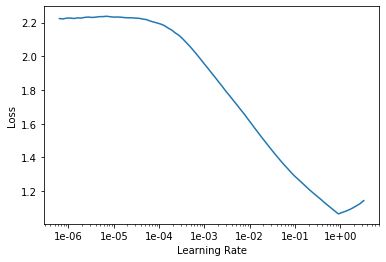

In [56]:
learn.lr_find(); learn.recorder.plot()

In [18]:
learn.fit_one_cycle(12, 1e-2)
learn.save('xr18_sample_'+zoom_level+'_256_autoencoder', return_path=True)

epoch,train_loss,valid_loss,time
0,0.225470,0.304152,05:36
1,0.138401,0.251764,05:36
2,0.133341,0.198266,05:35
3,0.113640,0.205918,05:35
4,0.112788,0.187417,05:35
5,0.091127,0.161371,05:36
6,0.081110,0.152559,05:36
7,0.076040,0.141482,05:35
8,0.072386,0.136407,05:35
9,0.070458,0.132379,05:35


PosixPath('/home/tc256760/Documents/Tabular_image_model/Sample Models/models/xr18_sample_zoom18_256_autoencoder.pth')

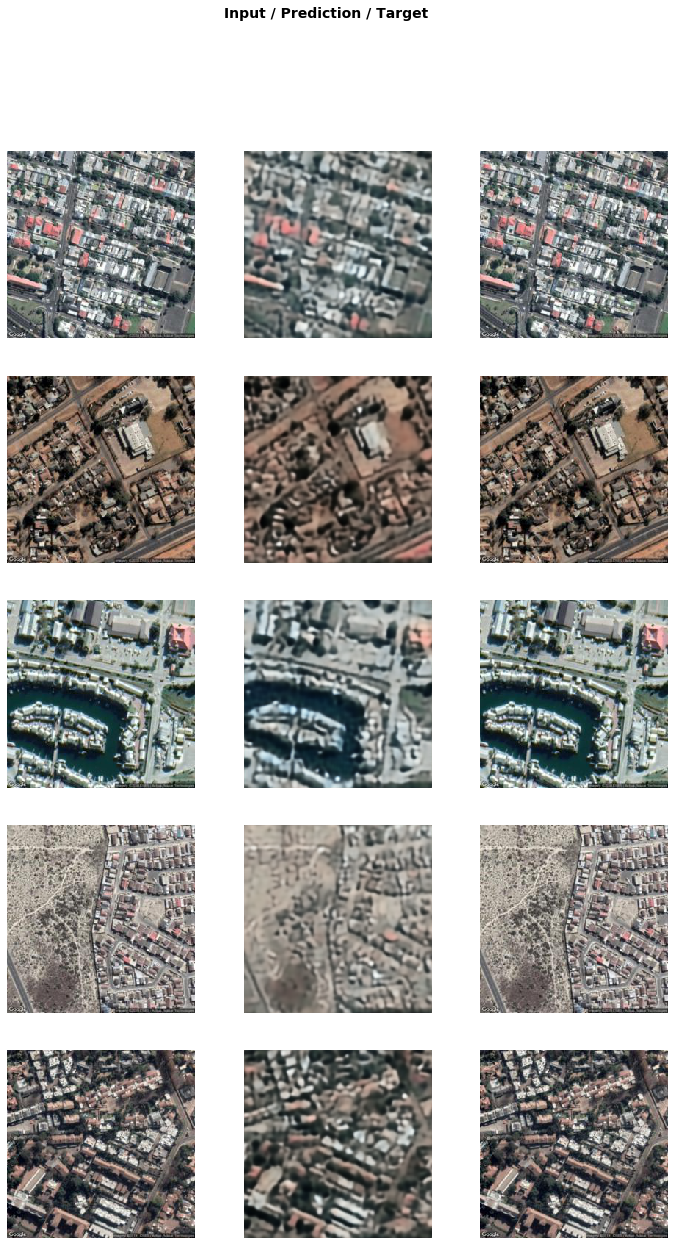

In [19]:
learn.show_results()

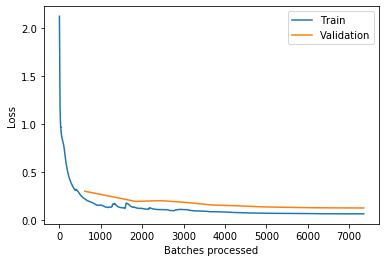

In [20]:
learn.recorder.plot_losses()

## Create Features

In [20]:
learn.load('xr18_sample_'+zoom_level+'_256_autoencoder');

In [21]:
def create_features(learn, test_df, path=Path.cwd(), feat_suffix='img_feat_'):
    "Cut model head and recover the feature map, returns DataFrame"
    learn.model = nn.Sequential(learn.model[0], nn.AdaptiveAvgPool2d(1), Flatten() )
    p, t = learn.get_preds(DatasetType.Test) #DatasetType.Test
    aux = DataFrame(to_np(p), columns = [(feat_suffix+str(k)) for k in range(p.shape[1])])
    features = pd.concat([test_df['cad_id'], aux], axis=1)
    return features

In [23]:
features = create_features(learn, available_images, PATH)

In [24]:
features.shape

(98157, 513)

In [26]:
features.to_pickle('sample_features_' + zoom_level + 'ae')